# XGBoost

In [308]:
import numpy as np
import pandas as pd
import xgboost as xgb

In [309]:
print(xgb.__version__)

0.7.post3


## Pipelines

* Takes a list of named 2-tuples `(name, pipeline_step)` as input
* Tuples can contain any arbitrary scikit-learn compatible estimator or transformer object
* Pipeline implements fit/predict methods
* Can be used as input estimator into grid/randomized search and `cross_val_score` methods


### Scikit-learn pipeline example

In [310]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

from sklearn.datasets import load_boston

In [315]:
import sklearn
print(sklearn.__version__)

0.19.1


In [328]:
# names = ['crime', 'zone', 'industry', 'charles',
#          'no', 'rooms', 'age', 'distance', 'radial',
#          'tax', 'pupil', 'sam', 'lower', 'med_price']

from sklearn.metrics import r2_score, make_scorer
r2_scorer = make_scorer(r2_score)

X, y = load_boston(return_X_y=True)

rf_pipeline = Pipeline([("st_scaler", StandardScaler()),
                       ("rf_model", RandomForestRegressor())])

scores = cross_val_score(rf_pipeline, X, y,
                         scoring=r2_scorer, cv=10)

In [330]:
final_avg_rmse = np.mean(np.sqrt(np.abs(scores)))
print("Final R2:", final_avg_rmse)

Final R2: 0.7290584971633406


### Preprocessing I: `LabelEncoder` and `OneHotEncoder`

* `LabelEncoder` converts a categorical column of strings into integers
* `OneHotEncoder` takes the column of integers and encodes them as dummy variables
* Cannot be done within a pipeline

### Preprocessing II: `DictVectorizer`
* Can do both from above
* Traditionally used in text processing
* Converts lists of feature mappings into vectors
* Need to convert DataFrame into a list of dictionary entries

### Ames Housing Exercise

In [23]:
!kg download -u neiljelmert -p DrummA13!? -c house-prices-advanced-regression-techniques

downloading https://www.kaggle.com/c/house-prices-advanced-regression-techniques/download/data_description.txt

data_description.txt 100% |##########################| Time: 0:00:01   9.1 KiB/s

downloading https://www.kaggle.com/c/house-prices-advanced-regression-techniques/download/train.csv.gz

train.csv.gz 100% |##################################| Time: 0:00:00 126.5 KiB/s

downloading https://www.kaggle.com/c/house-prices-advanced-regression-techniques/download/train.csv

train.csv 100% |#####################################| Time: 0:00:01 272.2 KiB/s

downloading https://www.kaggle.com/c/house-prices-advanced-regression-techniques/download/test.csv.gz

test.csv.gz 100% |###################################| Time: 0:00:00  98.8 KiB/s

downloading https://www.kaggle.com/c/house-prices-advanced-regression-techniques/download/test.csv

test.csv 100% |######################################| Time: 0:00:01 256.3 KiB/s

downloading https://www.kaggle.com/c/house-prices-advanced-regression-

In [5]:
df = pd.read_csv('train.csv')

In [6]:
df.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [7]:
# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Fill missing values with 0
# df = df.fillna(0)

# Create a boolean mask for categorical columns
categorical_mask = (df.dtypes == object)

# Get list of categorical column names
categorical_columns = df.columns[categorical_mask].tolist()
continuous_columns = df.columns[~categorical_mask].tolist()

df[categorical_columns] = df[categorical_columns].fillna("null_value")
df[continuous_columns] = df[continuous_columns].fillna(df.mean())

In [8]:
# Print the head of the categorical columns
# print(df[categorical_columns].head())

# Create LabelEncoder object: le
le = LabelEncoder()

# Apply LabelEncoder to categorical columns
df[categorical_columns] = df[categorical_columns]\
                            .apply(lambda x: le.fit_transform(x))

# Print the head of the LabelEncoded categorical columns
print(df[categorical_columns].head(1))

   MSZoning  Street  Alley  LotShape  LandContour  Utilities  LotConfig  \
0         3       1      2         3            3          0          4   

   LandSlope  Neighborhood  Condition1      ...        GarageType  \
0          0             5           2      ...                 1   

   GarageFinish  GarageQual  GarageCond  PavedDrive  PoolQC  Fence  \
0             1           4           4           2       3      4   

   MiscFeature  SaleType  SaleCondition  
0            4         8              4  

[1 rows x 43 columns]


### Note:
* `LabelEncoder` can force the assumption of ordered data, which can lead a model to poor performance
* As another step, we need to apply a one-hot-encoding to create binary variables

In [9]:
# Import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categorical_features=categorical_mask,
                    sparse=False)

# Apply OneHotEncoder to categorical columns
# output is no longer a dataframe: df_encoded
df_encoded = ohe.fit_transform(df)

# Print first 2 rows of the resulting dataset
print(df_encoded[:1, :10])

# Print the shape of the original DataFrame
print(df.shape)

[[0. 0. 0. 1. 0. 0. 1. 0. 0. 1.]]
(1460, 81)


### DictVectorizer
* The two-step process `LabelEncoder` --> `OneHotEncoder` can be simplified by using `DictVectorizer`
* Using `DictVectorizer` on a DataFrame that has been converted to a dictionary allows you to get label encoding as well as one-hot-encoding in one go

In [10]:
# Import DictVectorizer
from sklearn.feature_extraction import DictVectorizer

# Reload data
df = pd.read_csv('train.csv')

# Create a boolean mask for categorical columns
categorical_mask = (df.dtypes == object)

# Get list of categorical column names
categorical_columns = df.columns[categorical_mask].tolist()
continuous_columns = df.columns[~categorical_mask].tolist()

# Fill NaNs
df[categorical_columns] = df[categorical_columns].fillna("null_value")
df[continuous_columns] = df[continuous_columns].fillna(df.mean())

# Convert df into a dictionary: df_dict
df_dict = df.to_dict(orient = "records")

# Create the DictVectorizer object: dv
dv = DictVectorizer(sparse=False)

# Apply dv on df: df_encoded
df_encoded = dv.fit_transform(df_dict)

# Print the resulting first five rows
# print(df_encoded[:1,:2])

# Print the vocabulary
# print(dv.vocabulary_)

In [11]:
df_encoded.shape

(1460, 306)

### Preprocessing with a pipeline
* A cleaner and more succinct `DictVectorizer` approach integrated with `XGBoostRegressor` inside of a scikit-learn pipeline

In [12]:
# Import necessary modules
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline

# Reload & clean data
def load_clean(train, test):
    
    df_train = pd.read_csv(train)
    df_test = pd.read_csv(test)
    
    df = pd.concat([df_train, df_test], axis=0)
    
    start = df_test.shape[0]

    # Create a boolean mask for categorical columns
    categorical_mask = (df.dtypes == object)

    # Get list of categorical column names
    categorical_columns = df.columns[categorical_mask].tolist()
    continuous_columns = df.columns[~categorical_mask].tolist()

    # Fill NaNs
    df[categorical_columns] = df[categorical_columns].fillna("null_value")
    df[continuous_columns] = df[continuous_columns].fillna(df.mean())

    df_train = df.iloc[:start+1,:]
    df_test = df.iloc[start+1:,:]
    
    X_train = df_train.drop(['SalePrice'], axis=1)
    y_train = df_train['SalePrice']
    X_test = df_test.drop(['SalePrice'], axis=1)
    y_test = df_test['SalePrice']
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_clean("train.csv", "test.csv")

In [13]:
print(X_train.shape, X_test.shape)

(1460, 80) (1459, 80)


In [14]:
steps = [("dvectorizer", DictVectorizer(sparse=False)),
         ("xgb_model", xgb.XGBRegressor())]

# Create the pipeline
xgb_pipeline = Pipeline(steps)

# Fit the pipeline
xgb_pipeline.fit(X_train.to_dict(orient="records"), y_train)

Pipeline(memory=None,
     steps=[('dvectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=False)), ('xgb_model', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_ch...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [15]:
y_pred = xgb_pipeline.predict(X_test.to_dict("records"))
y_pred

array([123025.49, 162792.72, 175003.03, ..., 160798.  , 118364.26,
       235553.08], dtype=float32)

In [16]:
xgb_pipeline.score(X_train.to_dict("records"), y_train)

0.962714277784092

## Incorporating XGBoost into Pipelines

In [17]:
X, y = load_boston(True)

xgb_pipeline = Pipeline([("st_scaler", StandardScaler()),
                       ("xgb_model", xgb.XGBRegressor())])

scores = cross_val_score(xgb_pipeline, X, y,
                         scoring="neg_mean_squared_error", cv=10)

In [18]:
final_avg_rmse = np.mean(np.sqrt(np.abs(scores)))
print("Final RMSE:", final_avg_rmse)

Final RMSE: 4.000554517118832


## Additional Components for Pipelines

* `sklearn_pandas`:
    * `DataFrameMapper` - interpretability between `pandas` and `scikit-learn`
    * `CategoricalImputer` - Allow for imputation of categorical variables before integer conversion
* `sklearn.preprocessing`:
    * `Imputer` - Native implementation of numerical columns in scikit-learn
* `sklearn.pipeline`:
    * `FeatureUnion` - combine multiple pipelines of features into a single pipeline of features
    
    
### Cross-validating XGBoost

In [19]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

X_train, y_train, X_test, y_test = load_clean("train.csv", "test.csv")

steps = [("dict_vect", DictVectorizer(sparse=False)),
         ("xgb_model", xgb.XGBRegressor(max_depth=2, 
                                        objective="reg:linear")
         )]

xgb_pipeline = Pipeline(steps)

cross_val_scores = cross_val_score(xgb_pipeline,
                                   X_train.to_dict(orient="records"),
                                   y_train,
                                   cv=10,
                                   scoring="neg_mean_squared_error")

print("10-fold RMSE: ", np.mean(np.sqrt(np.abs(cross_val_scores))))

10-fold RMSE:  27167.271204387205


### Categorical Imputer

In [25]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00336/Chronic_Kidney_Disease.rar

--2018-03-16 17:25:52--  https://archive.ics.uci.edu/ml/machine-learning-databases/00336/Chronic_Kidney_Disease.rar
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19260 (19K) [text/plain]
Saving to: ‘Chronic_Kidney_Disease.rar’

Chronic_Kidney_Dise 100%[===================>]  18.81K  --.-KB/s    in 0.02s   

2018-03-16 17:25:52 (793 KB/s) - ‘Chronic_Kidney_Disease.rar’ saved [19260/19260]



In [20]:
from unrar import rarfile
rar = rarfile.RarFile('/Users/neiljelmert/Desktop/Projects/DataCamp/Chronic_Kidney_Disease.rar')

In [21]:
rar.namelist()

['Chronic_Kidney_Disease/chronic_kidney_disease.arff',
 'Chronic_Kidney_Disease/chronic_kidney_disease.info.txt',
 'Chronic_Kidney_Disease/chronic_kidney_disease_full.arff',
 'Chronic_Kidney_Disease']

In [34]:
rar.extractall()

In [55]:
from scipy.io import arff
# from io import StringIO

path = 'Chronic_Kidney_Disease/chronic_kidney_disease.arff'

# f = open(path, 'r')
# data, meta = arff.loadarff(f)

In [152]:
data = arff.loadarff(path)
df = pd.DataFrame(data[0])

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [163]:
# y = pd.factorize(y.values)[0].reshape(-1, 1)

In [300]:
X, y, X_test, y_test = load_clean("train.csv", "test.csv")
y = y > y.mean()
# y = pd.factorize(y.values)[0].reshape(-1, 1)

from sklearn_pandas import DataFrameMapper
from sklearn_pandas import CategoricalImputer
from sklearn.preprocessing.imputation import Imputer

# Check number of nulls in each feature
nulls_per_column = X.isnull().sum()
# print(nulls_per_column)

# Create a boolean mask for categorical columns
categorical_feature_mask = X.dtypes == object

# Get list of categorical column names
categorical_columns = X.columns[categorical_feature_mask].tolist()

# Get list of numeric column names
numeric_columns = X.columns[~categorical_feature_mask].tolist()

# Apply numeric imputer
map_num = [
           ([numeric_feature],
            Imputer(strategy="median")) for numeric_feature in
            numeric_columns
            ]
        
numeric_imputation_mapper = DataFrameMapper(map_num,
                                            input_df=True,
                                            df_out=True)

# Apply categorical imputer
map_cat = [
            ([category_feature],
             CategoricalImputer()) for category_feature in
             categorical_columns
            ]

categorical_imputation_mapper = DataFrameMapper(map_cat,
                                                input_df=True,
                                                df_out=True)

### Feature Union

* Use `FeatureUnion` to concatenate the results of numeric and categorical imputation

In [301]:
from sklearn.pipeline import FeatureUnion

In [302]:
fu = [("num_mapper", numeric_imputation_mapper),
      ("cat_mapper", categorical_imputation_mapper)]
numeric_categorical_union = FeatureUnion(fu)

### Full Pipeline

In [348]:
from sklearn.base import BaseEstimator, TransformerMixin

class Dictifier(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if type(X) == pd.core.frame.DataFrame:
            return X.to_dict(orient="records")
        else:
            return pd.DataFrame(X).to_dict(orient="records")
        
    def fit_transform(self, X, y=None, **fit_params):
        if y is None:
            return self.fit(X, **fit_params).transform(X)
        else:
            return self.fit(X, y, **fit_params).transform(X)

In [349]:
# y.unique()
# y_bin = y.apply(lambda x: 0 if x==b'ckd' else 1)

In [350]:
pipeline = Pipeline([
                        ("num_cat_union", numeric_categorical_union),
                        ("dictifier", Dictifier()),
                        ("vectorizer", DictVectorizer(sort=False)),
                        ("xgb_model", xgb.XGBClassifier())
                    ])

cross_val_scores = cross_val_score(pipeline,
                                   X, y,
                                   scoring="roc_auc", 
                                   cv=3)

print("3-fold AUC: ", np.mean(cross_val_scores))
print(cross_val_scores)

3-fold AUC:  0.979747091407433
[0.98511586 0.9826738  0.97145161]


In [351]:
from sklearn.metrics import classification_report

## Tuning XGBoost Hyperparameters in a Pipeline

In [363]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [366]:
X, y, X_test, y_test = load_clean("train.csv", "test.csv")
y = y > y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# steps = [("st_scalar", StandardScaler()),
#          ("xgb_model", xgb.XGBClassifier())]

# xgb_pipeline = Pipeline(steps)

# Must be of format "modelname__hyperparamter"
gbm_param_grid = {
                    "xgb_model__subsample":        np.arange(0.05, 1, 0.5),
                    "xgb_model__max_depth":        np.arange(3, 20, 1),
                    "xgb_model__colsample_bytree": np.arange(0.1, 1.05, 0.05),
                    "xgb_model__learning_rate":    np.arange(0.05, 1, 0.05),
                    "xgb_model__n_estimators":     np.arange(50, 200, 50)
                  }

randomized_roc_auc = RandomizedSearchCV(estimator=pipeline,
                                        param_distributions=gbm_param_grid,
                                        n_iter=10,
                                        scoring="roc_auc",
                                        cv=4)

randomized_roc_auc.fit(X_train, y_train)
print(randomized_roc_auc.best_score_)
print(randomized_roc_auc.best_estimator_)

0.9766735110463316
Pipeline(memory=None,
     steps=[('num_cat_union', FeatureUnion(n_jobs=1,
       transformer_list=[('num_mapper', DataFrameMapper(default=False, df_out=True,
        features=[(['1stFlrSF'], Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), (['2ndFlrSF'], Imputer(axis=0, copy=True, missing_valu...g_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.55))])


In [367]:
randomized_roc_auc.best_estimator_

Pipeline(memory=None,
     steps=[('num_cat_union', FeatureUnion(n_jobs=1,
       transformer_list=[('num_mapper', DataFrameMapper(default=False, df_out=True,
        features=[(['1stFlrSF'], Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), (['2ndFlrSF'], Imputer(axis=0, copy=True, missing_valu...g_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.55))])

In [368]:
randomized_roc_auc.best_params_

{'xgb_model__colsample_bytree': 1.0000000000000004,
 'xgb_model__learning_rate': 0.1,
 'xgb_model__max_depth': 13,
 'xgb_model__n_estimators': 50,
 'xgb_model__subsample': 0.55}

In [369]:
randomized_roc_auc.cv_results_

/Users/neiljelmert/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/neiljelmert/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/neiljelmert/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **w

{'mean_fit_time': array([0.54497212, 0.59041476, 0.47047448, 0.52236331, 0.48240924,
        0.47360826, 0.58614177, 0.44979501, 0.51692301, 0.53910232]),
 'mean_score_time': array([0.16393071, 0.15573049, 0.14320296, 0.14120972, 0.14978224,
        0.16185522, 0.154971  , 0.15920198, 0.14381123, 0.14698899]),
 'mean_test_score': array([0.96595976, 0.97586235, 0.9578313 , 0.97504377, 0.96919866,
        0.95516793, 0.97667351, 0.96147276, 0.9762384 , 0.96743602]),
 'mean_train_score': array([1.        , 1.        , 0.96726464, 1.        , 0.97917497,
        0.96893195, 0.99958389, 0.97620454, 0.99904073, 1.        ]),
 'param_xgb_model__colsample_bytree': masked_array(data=[0.30000000000000004, 0.6000000000000002,
                    0.6000000000000002, 0.20000000000000004,
                    0.40000000000000013, 0.7500000000000002,
                    1.0000000000000004, 1.0000000000000004,
                    0.9500000000000003, 0.25000000000000006],
              mask=[False, Fals

In [460]:
randomized_roc_auc.predict_proba(X_test)[:,1].shape

(292,)

In [372]:
randomized_roc_auc.score(X_test, y_test)

0.9870675256502027

In [465]:
def report_best_thresh(y_probs, y_true):
    
    if y_probs.shape[1] == 2:
        y_probs = y_probs[:,1]
    else:
        pass
    
    assert(y_probs.shape == (y_true.shape[0],))
        
    thresholds = np.arange(0.0, 1.0, 0.01)
    recall = []
    precision = []
    
    decision = lambda x: 1 if x > t else 0
    dec_vec = np.vectorize(decision)
    
    for t in thresholds:
        t_pred = dec_vec(y_probs)
        
        tp = np.sum((t_pred == 1) & (y_true == 1))
        fp = np.sum((t_pred == 1) & (y_true == 0))
        fn = np.sum((t_pred == 0) & (y_true == 1))
        prec = tp/(tp+fp)
        rec = tp/(tp+fn)
    
        precision.append(prec)
        recall.append(rec)
    
    argmax = np.argmax(np.array(precision) + np.array(recall))
    
    return thresholds[argmax]

In [466]:
report_best_thresh(randomized_roc_auc.predict_proba(X_test), y_test)

0.44

In [455]:
print(precision[44], recall[44])
print(thresh[44])

0.9590163934426229 0.9212598425196851
0.44


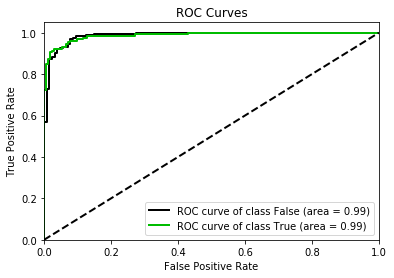

In [385]:
import scikitplot as skplt

y_true = y_test
y_probas = randomized_roc_auc.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_true, y_probas, curves=('each_class'))
plt.show()

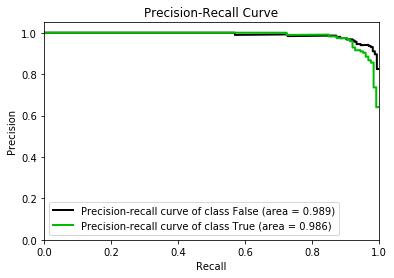

In [386]:
skplt.metrics.plot_precision_recall_curve(y_test, y_probas, curves=('each_class'))
plt.show()

/Users/neiljelmert/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


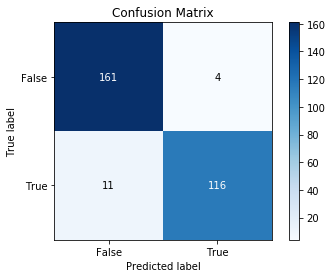

In [384]:
preds = randomized_roc_auc.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_true=y_test, y_pred=preds)
plt.show()

In [337]:
best_xgb = randomized_roc_auc.best_estimator_

In [338]:
pipeline.steps[3][1]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [339]:
best_xgb.fit(X,y)

Pipeline(memory=None,
     steps=[('num_cat_union', FeatureUnion(n_jobs=1,
       transformer_list=[('num_mapper', DataFrameMapper(default=False, df_out=True,
        features=[(['1stFlrSF'], Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), (['2ndFlrSF'], Imputer(axis=0, copy=True, missing_valu...     reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.55))])

In [340]:
best_xgb.steps[3][1]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.55)

In [341]:
X.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,null_value,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,null_value,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,null_value,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,null_value,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,null_value,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [347]:
pipeline.fit_transform(X.iloc[:5,:])

ValueError: bad input shape ()

In [ ]:
best_xgb.predict_proba([])

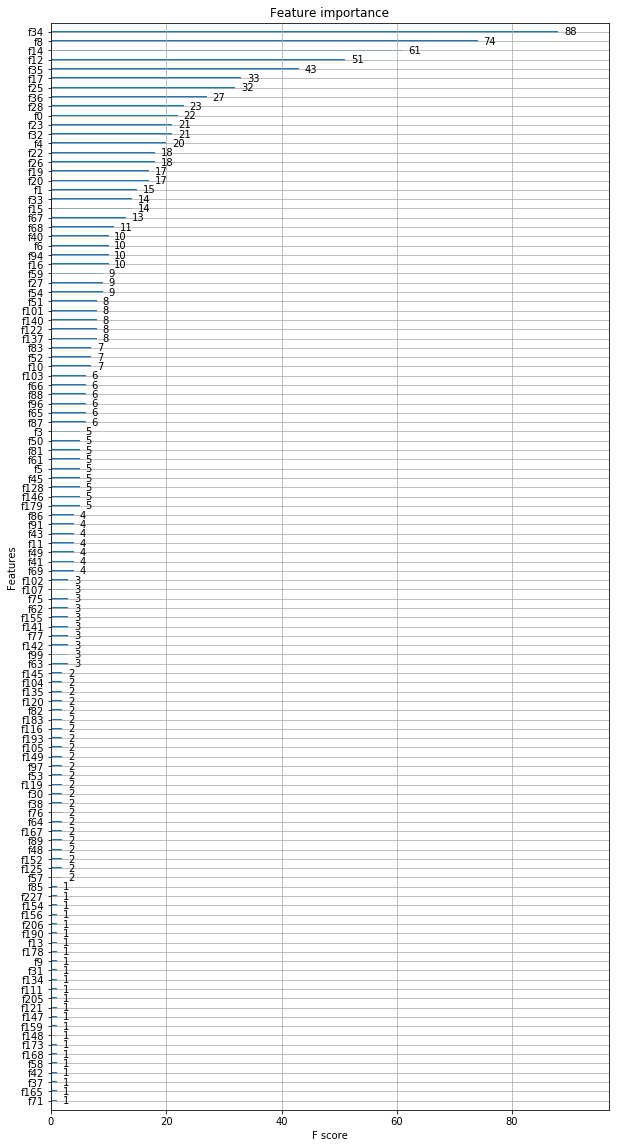

In [294]:
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import plot_importance

# plt.plot(best_xgb.steps[3][1].feature_importances_)
fig, ax = plt.subplots(figsize=(10, 20))
plot_importance(best_xgb.steps[3][1], ax=ax)